In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime

## Chapter 0 Preface

This book is an introduction to the practical tools of exploratory data analysis. The organization of the book follows the process I use when I start working with a dataset:

* Importing and cleaning: Whatever format the data is in, it usually takes some time and effort to read the data, clean and transform it, and check that everything made it through the translation process intact.
* Single variable explorations: I usually start by examining one variable at a time, finding out what the variables mean, looking at distributions of the values, and choosing apprpriate summary statistics
* Pair-wise explorations: To identify possible relationships between variables, I look at tables and scatter plots, and compute correlations and linear fits
* Multivariate analysis: If there are apparent relationships between variables, I use multiple regression to add control variables and investigate more complex relationships
* Estimation and hypothesis testing: When reporting statistical results, it is important to answer three questions: How big is the effect? How much variability should we expect if we run the same measurement again? Is it possible that the apparent effect is due to chance?
* Visualization: During exploration, visualization is an important tool for finding possible relationships and effects. Then if an apparent effect holds up to scrutiny, visualization is an effective way to communicate results.

http://nbviewer.jupyter.org/github/barbagroup/AeroPython/blob/master/lessons/01_Lesson01_sourceSink.ipynb

In [37]:
#from IPython.core.display import HTML
#def css_styling():
#    styles = open('../styles/custom.css', 'r').read()
#    return HTML(styles)
#css_styling()

This book takes a comuational approach, which has several advantages over mathematical approaches:

* I present most ideas using Python code, rather than mathematical notation. In general, Python code is more readable; also, because it is executable, readers can download it, run it, and modify it.
* Each chapter includes exercises readers can do to develop and solidify their learning. When you write programs, you express your understanding in code; while you are debugging the program, you are also correcting your understanding.

* Some exercises involve experiments to test statistical behavior. For example, you can explore the Central Limit Theorem (CLT) by generating random samples and computing their sums. The resulting visiualizations demonstrate why the CLT works and and when it doesn't.
* Some ideas that are hard to grasp mathematically are easy to understand by simulation. For example, we approximate p-values by running random simulations, which reinforces the meaning of the p-value.
* Because the book is based on a general-purpose programming language (Python), readers can import data from almost any source. They are not limited to datasets that have been cleaned and formatted for a partciular statistics tool.

The book lends itself to a project-based approach. In my class, students work on a semester-long project that requires them to pose a statistical question, find a dataset that can address it, and apply each of the techniques they learn to their own data.

To demonstrate my approach to statistical analysis, the book presents a case study that runs through all of the chapters. It uses data from two sources:

* The Natoinal Survey of Family Growth (NSFG), conducted by the U.S. Centers for Disease Control and Prevention (CDC) to gather "information on family life, marriage and divorce, pregnancy, infertility, use of contraception, and men's and women's health." (See http://cdc/gov/nchs/nsfg.html)
* The Behavioral Risk Factor Surveillance System (BRFSS), conducted by the National Center for Chronic Disease and Prevention and Health Promotion to "track conditions and risk behaviors in the United States." (See http://cdc.gov/BRFSS/)

Other examples use data from the IRS, the U.S. Census, and the Boston Marathon.

This second edition of _Think Stats_ includes the chapters from the first edition, many of them substantially revised, and new chapters on regression, time series analysis, survival analysis, and analytic methods. The previous edition did not use pandas, SciPy, or StatsModels, so all of that material is new.

In [38]:
#from IPython.core.display import HTML
#def css_styling():
#    styles = open('theme/serif.css', 'r').read()
#    return HTML(styles)
#css_styling()

## <font color='teal'> 0.1 How I wrote this book</font>

When people write a new textbook, they usually start by reading a stack of old textbooks. As a result, most books contain the same material in pretty much the same order.

I did not do that. In fact, I used almost no printed material while I was writing this book, for several reasons:

* My goal was to explore a new approach to this material, so I didn't want much exposure to existing approaches.
* Since I am making this book available under a free license, I wanted to make sure that no part of it was encumbered by copyright restrictions.
* Many readers of my books don't ahve access to libraries of printed material, so I triedto make references to resources that are freely available on the internet.
* Some proponents of old media think that the exclusive use of electronic resources is lazy and unreliable. They might be right about the first part, but I think they are wrong about the second, so I wanted to test my theory.

The resource I used more than any other is Wikipedia. In general, the articles I read on statistical topics were very good (although I made a few small changes along the way). I  include references to Wikipedia pages throughout the book and I encourage you to follow those links; in many cases, the Wikipedia page picks up where my description leaves off. The vocabulary and notation in this book are generally consistent with Wikipedia, unless I had a good reason to deviate. Other resources I found useful were Wolfram MathWorld and the Reddit statistics forum, http://www.reddit.com/r/statistics

## <font color='teal'>0.2 Using the code</font>

The code and data used in this book are available from https://github/com/AllenDowney/ThinkStats2. Git is a veresoin control system that allows you to keep track of the files that make up a project. A Collection of files under Git's control is called a **repository**. GitHub is a hosting service that provides storage for Git repositories and a convenient web interface.

The GitHub homepage for my repository provides several ways to work with the code:

* You can create a copy of my repository on GitHub by pressing the Fork button. If you don't already have a GitHub account, you'll need to create one. After forking, you'll have your own repository on GitHub that you can use to keep track of code you write while working on this book. Then you can clone the repo, which means that you make a copy of hte files on your computer.
* Or you could clone my reopsitory. You don't need a GitHub account to do this, but you won't be able to write any changes back to GitHub.
* If you don't want to use Git at all, you can download the files in a Zip file using the button in the lower-right corner of the GitHub page.

All of the code is written to work in both Python 2 and Python 3 with no translation.

I developed this book using Anaconda from Continuum Analytics, which is a free Python distribution tha tincludes all the packages you'll need to run the code (and lots more). I found Anaconda easy to install. By default it does a user-level installaiton, not a system-level, so you don't need administrative privileges. And it supports both Python 2 and Python 3. You can download Anaconda from http://conintuum.io/downloads

If you don't want to use Anaconda, you will need the following packages:

* pandas for representing and analyzing data, http://pandas.pydata.org
* NumPy for basic numerical computation, http://www.numpy.org
* SciPy for scientific computation including statistics, http://www.scipy.org
* StatsModels for regression and other statistical analysis, http://statsmodels.sourceforge.net ; and
* matplotlib for visualization, http://matplotlib.org

Although these are commonly used packages, they are not included with all Python installations, and they can be hard to install in some environments. If you are having trouble installing them, I strongly recommend using Anaconda or one of the other Python distributions that include these packages.

After you clone the repository or unzip the zip file, you should have a folder called ```ThinkStats2/code``` with a file called ```nsfg.py```. If you run nsfg.py, it should read a data file, run some tests, and print a message like, "All tests passed." If you get import errors, it probably means there are packages you need to install.

In [39]:
%run nsfg.py

(13593, 244)
nsfg.py: All tests passed.


Most exercises use Python scripts, but some also use the IPython notebook. If you have not used IPython notebook before, I suggest you start with the documentation at http://ipython.org/ipython-doc/stable/notebook/notebook.html

I wrote this book assuming that the reader is familiar with core Python, including object-oriented features, but not pandas, NumPy, and SciPy. If you are already familiar with these modules, you can skip a few sections.

I assume that the reader knows basic mathematics, including logarithms, for example, and summations. I refer to calculus concepts in a few places, but you don't have to do any calculus.

If you have never studied statistics, I think this book is a good place to start. And if you have taken a traditional statistics class, I hope this book will help repaair the damage.

## <font color='teal'>Chapter 1 Exploratory data Analysis</font>

The thesis of this book is that data combined with practical methods can answer questions and guide decisions under uncertainty.

As an example, I present a case study motivated by a question I heard when my wife and I were expecting our first child: do first babies tend to arrive late?

If you Google this question, you will find plenty of discussion. Some people claim it's true, others say it's a myth, and some people say it's the other way around: first babies come early.

In many of these discussions, people provide data to support their claims. I found many examples like these:

* "My two friends that have given birth recently to their first babies, BOTH went almost 2 weeks overdue before going into labour or being induced."
* "My first one came 2 weeks late and now I think the second one is going to come out two weeks early!!"
* "I don't think that can be true because my sister was my mother's first and she was early, as with many of my cousins."


Reports like these are called **anecdotal evidence** because they are based on data that is unpublished and usually personal. In casaul conversation, there is nothing wrong with anecdotes, so I don't mean to pick on the people I quoted.

But we might want evidence that is more persuasive and an answer that is more realiable. By those standards, anecdotal evidence usually fails, because:

* Small number of observations: If pregnancy length is longer for first babies, the difference is probably small compared to natural variation. In that case, we might have to compare a large number of pregnancies to be sure that a difference exists.
* Selection bias: People who join a discussion of this question might be interested because their first babies were late. In that case the process of selecting data would bias the results.
* Confirmation bias: People who believe the claim might be more likely to contribute examples that confirm it. People who doubt the claim are more likely to cite counterexamples.
* Inaccuracy: Anecdotes are often personal stories, and oftem misremembered, misrepresetned, repeated inaccurately, etc.

So how can we do better?

## <font color='teal'>1.1 A statistical approach</font>

To address the limitations of anecdotes, we will use the tools of statistics, which include:

* Data collection: We will use data from a large national survey that was designed explicitly with the goal of generating statistically valid inferences about the U.S. population.
* Descriptive statistics: We will generate statistics that summarize the data concisely, and evluate different ways to visualize data.
* Exploratory data analysis: We will look for patterns, differences, and other features that address the questions we are interested in. At the same time we will check for inconsistencies and identify limitations.
* Estimation: We will use data from a sample to estimate characteristics of the general population.
* Hypothesis testing: Where we see apparent effects, like a difference between two groups, we will evaluate whether the effect might have happened by chance.

By performing these steps with care to avoid pitfalls, we can reach conclusions that are more justifiable and more likely to be correct.

### <font color='teal'>1.2 The National Survey of Family Growth</font>

Since 1973 the U.S. Centers for Disease Control and Prevention (CDC) have conducted the National Survey of Family Growth (NSFG), which is intended to gather "information on family life, marriage and divorce, pregnancy, infertility, use of contraception, and men's and women's health. The survey results are used ... to plan health services and health education programs, and to do statistical studies of families, fertility, and health." See http://cdc.gov.nchs/nsfg.htm

We will use data collected by this survey to investigate whether first babies tend to come late, and other questions. In order to use this data effectively, we have to understand the design of the study.

The NSFG is a **cross-sectional** study, which means that it captures a snapshot of a group at a point in time. The most common alternative is a **longitudinal** study, which observes a group repeatedly over a period of time.

The NSFG has  been conducted seven times; each deployment is called a **cycle**. We will use data from Cycle 6, which was conducted from January 2002 to March 2003.

The goal of the survey is to draw conclusions about a **population**; the target population of the NSFG is people in the United States aged 15-44. Ideally surveys would collect data from every member of the population, but that's seldom possible. Instead we collect data from a subset of the population called a **sample**. The people who particpate in a survey are called **respondents**.

In general, cross-sectional studies are meant to be **representative**, which means that every member of the target population has an equal chance of particpating. That ideal is hard to achieve in practice, but people who conduct surveys come as close as they can,

The NSFG is not representative; instead it is deliberately **oversampled**. The designers of the study recruited through groups - Hispanics, African-Americans and teenagers - at rates higher than their representation in the U.S. population, in order to make sure that the number of reponsdents in each of these groups is large enough to draw valid statistical inferences.

Of course, the drawback of oversmapling is that it is not easy to draw conclusions about the general population based on statistics from the survey. We will com eback to this point later.

When wroking with this kind of data, it is important to be familiar with the **codebook**, which documents the design of the study, the survey questions, and the encoding of the reponses. The codebook and user's guide for the NSFG data are available from http://www.cdc.nchs/nsfg/nsfg_cycle6.html

## <font color='teal'>1.3 Importing the data</font>

The code and data used in this book are available from https://github/AllenDowney/ThinkStats2 .
Once you download the code, you should have a file called ```ThinkStats2/code/nsfg.py``` . If you run it, it should read a 
data file, run some tests, and print a message like "All tests passesd."

Let's see what it does. Pregnancy data from Cycle 6 of the NSFG is in a filed called ```2002FemPreg.dat.gz```; it is a 
gzip-compressed data file in plain text (ASCII), with fixed width columns. Each line in the file is a **record** that contains data about one pregnancy.

The format of the file is documented in ```2002FemPreg.dct```, which is a Stata dictionary file. Stata is a statistical software system; a "dictionary" in this context is a list of variable names, types, and indices that identify where in each line fo find each variable.

In [ ]:
# %load '2002FemPreg.dct'
infile dictionary {
    _column(1)      str12                             caseid  %12s  "RESPONDENT ID NUMBER"
   _column(13)       byte                           pregordr   %2f  "PREGNANCY ORDER (NUMBER)"
   _column(15)       byte                          howpreg_n   %2f  "BB-2 # OF WEEKS OR MONTHS CURRENTLY PREGNANT"
   _column(17)       byte                          howpreg_p   %1f  "BB-2 CURRENT PREGNANCY LENGTH REPORTED IN MONTHS OR WEEKS"
   _column(18)       byte                           moscurrp   %1f  "NUMBER OF MONTHS CURRENTLY PREGNANT"
   _column(19)       byte                           nowprgdk   %1f  "BB-3 WHICH TRIMESTER -- CURRENT PREGNANCY"
   _column(20)       byte                           pregend1   %1f  "BC-1 HOW PREGNANCY ENDED - 1ST MENTION"
   _column(21)       byte                           pregend2   %1f  "BC-1 HOW PREGNANCY ENDED - 2ND MENTION"
   _column(22)       byte                           nbrnaliv   %1f  "BC-2 NUMBER OF BABIES BORN ALIVE FROM THIS PREGNANCY"
   _column(23)       byte                           multbrth   %1f  "BC-3 WAS THIS A MULTIPLE BIRTH"
   _column(24)        int                           cmotpreg   %4f  "CM FOR PREGNANCY END DATE (IF NONLIVEBIRTH)"
   _column(28)       byte                         prgoutcome   %1f  "OUTCOME OF PREGNANCY (BASED ON PRIORITY ORDERING)"
   _column(29)        int                           cmprgend   %4f  "CM FOR PREGNANCY END DATE (REGARDLESS OF OUTCOME)"
   _column(33)       byte                           flgdkmo1   %1f  "FLAG INDICATING SEASON/DK/RF FOR BC-4A DATPRGEN_M"
   _column(34)        int                           cmprgbeg   %4f  "CM FOR PREGNANCY START DATE"
   _column(38)       byte                           ageatend   %2f  "BC-4B R'S AGE AT PREGNANCY'S END DATE"
   _column(40)       byte                           hpageend   %2f  "BC-4C FATHER'S AGE AT PREGNANCY'S END DATE"
   _column(42)       byte                         gestasun_m   %2f  "BC-5 GESTATIONAL LENGTH OF PREGNANCY IN MONTHS"
   _column(44)       byte                         gestasun_w   %2f  "BC-5 GESTATIONAL LENGTH OF PREGNANCY IN WEEKS"
   _column(46)       byte                            wksgest   %2f  "GESTATIONAL LENGTH OF COMPLETED PREGNANCY (IN WEEKS)"
   _column(48)       byte                            mosgest   %2f  "GESTATIONAL LENGTH OF COMPLETED PREGNANCY (IN MONTHS)"
   _column(50)       byte                            dk1gest   %1f  "BC-6 DK FOLLOWUP FOR GESTATIONAL LENGTH OF A STILLBIRTH"
   _column(51)       byte                            dk2gest   %1f  "BC-7 DK FOLLOWUP FOR GESTATIONAL LENGTH OF A LIVEBIRTH"
   _column(52)       byte                            dk3gest   %1f  "BC-8 DK FOLLOWUP FOR GESTATIONAL LENGTH OF A MISCARR/ABOR/ECTOP"
   _column(53)       byte                      bpa_bdscheck1   %1f  "WHETHER 1ST LIVEBORN BABY FROM THIS PREGNANCY WAS BPA OR BDS"
   _column(54)       byte                      bpa_bdscheck2   %1f  "WHETHER 2ND LIVEBORN BABY FROM THIS PREGNANCY WAS BPA OR BDS"
   _column(55)       byte                      bpa_bdscheck3   %1f  "WHETHER 3RD LIVEBORN BABY FROM THIS PREGNANCY WAS BPA OR BDS"
   _column(56)       byte                            babysex   %1f  "BD-2 SEX OF 1ST LIVEBORN BABY FROM THIS PREGNANCY"
   _column(57)       byte                        birthwgt_lb   %2f  "BD-3 BIRTHWEIGHT IN POUNDS - 1ST BABY FROM THIS PREGNANCY"
   _column(59)       byte                        birthwgt_oz   %2f  "BD-3 BIRTHWEIGHT IN OUNCES - 1ST BABY FROM THIS PREGNANCY"
   _column(61)       byte                           lobthwgt   %1f  "BD-4 IS BABY LOW BIRTHWEIGHT- 1ST BABY FROM THIS PREGNANCY"
   _column(62)       byte                           babysex2   %1f  "BD-2 SEX OF 2ND LIVEBORN BABY FROM THIS PREGNANCY"
   _column(63)       byte                       birthwgt_lb2   %2f  "BD-3 BIRTHWEIGHT IN POUNDS - 2ND BABY FROM THIS PREGNANCY"
   _column(65)       byte                       birthwgt_oz2   %2f  "BD-3 BIRTHWEIGHT IN OUNCES - 2ND BABY FROM THIS PREGNANCY"
   _column(67)       byte                          lobthwgt2   %1f  "BD-4 IS BABY LOW BIRTHWEIGHT- 2ND BABY FROM THIS PREGNANCY"
   _column(68)       byte                           babysex3   %1f  "BD-2 SEX OF 3RD LIVEBORN BABY FROM THIS PREGNANCY"
   _column(69)       byte                       birthwgt_lb3   %2f  "BD-3 BIRTHWEIGHT IN POUNDS - 3RD BABY FROM THIS PREGNANCY"
   _column(71)       byte                       birthwgt_oz3   %2f  "BD-3 BIRTHWEIGHT IN OUNCES - 3RD BABY FROM THIS PREGNANCY"
   _column(73)       byte                          lobthwgt3   %1f  "BD-4 IS BABY LOW BIRTHWEIGHT- 3RD BABY FROM THIS PREGNANCY"
   _column(74)        int                           cmbabdob   %4f  "CM FOR BABY'S OR BABIES' DATE OF BIRTH (DELIVERY DATE)"
   _column(78)        int                             kidage   %4f  "CURRENT AGE (IN MOS) OF R'S CHILD(REN) FROM THIS PREGNANCY"
   _column(82)       byte                            hpagelb   %2f  "BD-6 FATHER'S AGE AT TIME OF CHILD(REN) S BIRTH"
   _column(84)       byte                           birthplc   %1f  "BD-7 PLACE WHERE R GAVE BIRTH"
   _column(85)       byte                          paybirth1   %1f  "BD-8 PAYMENT FOR DELIVERY - 1ST MENTION"
   _column(86)       byte                          paybirth2   %1f  "BD-8 PAYMENT FOR DELIVERY - 2ND MENTION"
   _column(87)       byte                          paybirth3   %1f  "BD-8 PAYMENT FOR DELIVERY - 3RD MENTION"
   _column(88)       byte                           knewpreg   %2f  "BE-1 WEEKS PREGNANT WHEN R LEARNED SHE WAS PREGNANT"
   _column(90)       byte                           trimestr   %1f  "BE-2A DK FOLLOWUP FOR KNEWPREG WHEN GESTATION >= 6 MOS"
   _column(91)       byte                           ltrimest   %1f  "BE-2B DK FOLLOWUP FOR KNEWPREG WHEN GESTATION < 6 MOS"
   _column(92)       byte                           priorsmk   %1f  "BE-3 AMOUNT R'SMOKED IN 6 MOS BEFORE R KNEW SHE WAS PREGNANT"
   _column(93)       byte                           postsmks   %1f  "BE-4 R'SMOKED AT ALL AFTER R KNEW SHE WAS PREGNANT"
   _column(94)       byte                           npostsmk   %1f  "BE-5 AMOUNT R'SMOKED DURING PREGNANCY AFTER R KNEW SHE WAS PREG"
   _column(95)       byte                           getprena   %1f  "BE-6 ANY PRENATAL CARE FOR THIS PREGNANCY"
   _column(96)       byte                           bgnprena   %2f  "BE-7 WEEKS PREGNANT AT FIRST PRENATAL CARE VISIT"
   _column(98)       byte                            pnctrim   %1f  "BE-8A DK FOLLOWUP FOR BGNPRENA WHEN GESTATION >= 6 MOS"
   _column(99)       byte                            lpnctri   %1f  "BE-8B DK FOLLOWUP FOR BGNPRENA WHEN GESTATION < 6 MOS"
  _column(100)       byte                           workpreg   %1f  "BF-1 R WORKED AT ALL DURING THIS PREGNANCY"
  _column(101)       byte                           workborn   %1f  "BF-2 MATERNITY LEAVE TAKEN FOR THIS PREGNANCY"
  _column(102)       byte                            didwork   %1f  "BF-3 WHY NO MATERNITY LEAVE WAS TAKEN FOR THIS PREGNANCY"
  _column(103)       byte                           matweeks   %2f  "BF-4 WEEKS OF MATERNITY LEAVE TAKEN FOR THIS PREGNANCY"
  _column(105)       byte                            weeksdk   %1f  "BF-5 DK FOLLOWUP - WAS MATERNITY LEAVE <=4 OR > 4 WEEKS"
  _column(106)       byte                           matleave   %2f  "BF-6 WEEKS OF PAID MATERNITY LEAVE FOR THIS PREGNANCY"
  _column(108)       byte                         matchfound   %1f  "CHECK ON WHETHER CHILD MATCHES BIO CHILD IN HH ROSTER - 1ST"
  _column(109)       byte                           livehere   %1f  "BG-1 WHETHER CHILD LIVES WITH R - 1ST FROM THIS PREGNANCY"
  _column(110)       byte                           alivenow   %1f  "BG-2 WHETHER CHILD IS STILL ALIVE - 1ST FROM THIS PREGNANCY"
  _column(111)        int                           cmkidied   %4f  "CM FOR CHLD'S DATE OF DEATH - 1ST FROM THIS PREGNANCY"
  _column(115)        int                           cmkidlft   %4f  "CM FOR DATE CHILD STOPPED LIVING W/R - 1ST FROM THIS PREGNANCY"
  _column(119)        int                            lastage   %3f  "AGE (IN MOS) WHEN CHILD LAST LIVED W/R-1ST FROM THIS PREGNANCY"
  _column(122)       byte                           wherenow   %1f  "BG-5 WHERE CHILD LIVES NOW - 1ST FROM THIS PREGNANCY"
  _column(123)       byte                           legagree   %1f  "BG-6 LEGAL AGREEMENT FOR WHERE CHILD LIVES - 1ST FROM THIS PREG"
  _column(124)       byte                           parenend   %1f  "BG-7 IS R STILL LEGAL MOTHER OF CHILD - 1ST FROM THIS PREGNANCY"
  _column(125)       byte                           anynurse   %1f  "BH-1 WHETHER R BREASTFED THIS CHILD AT ALL - 1ST FROM THIS PREG"
  _column(126)       byte                           fedsolid   %1f  "BH-2 HAS R BEGUN SUPPLEMENTATION FOR CHILD - 1ST FROM THIS PREG"
  _column(127)        int                         frsteatd_n   %3f  "BH-3 AGE (MOS/WKS/DAY) WHEN 1ST SUPPLEMENTED - 1ST FROM THIS PREG"
  _column(130)       byte                         frsteatd_p   %1f  "BH-3 UNITS (MOS/WKS/DAYS) FOR FRSTEATD_N - 1ST FROM THIS PREG"
  _column(131)        int                           frsteatd   %3f  "AGE (IN MOS) WHEN 1ST SUPPLEMENTED - 1ST FROM THIS PREG"
  _column(134)       byte                           quitnurs   %1f  "BH-4 HAS R'STOPPED BREASTFEEDING CHILD - 1ST FROM THIS PREG"
  _column(135)        int                         ageqtnur_n   %3f  "BH-5 AGE (MOS/WKS/DAY) WHEN STOPPED BREASTFEEDING - 1ST FROM THIS PREG"
  _column(138)       byte                         ageqtnur_p   %1f  "BH-5 UNITS (MOS/WKS/DAYS) FOR AGEQTNUR_N - 1ST FROM THIS PREG"
  _column(139)        int                           ageqtnur   %3f  "AGE (IN MOS) WHEN R'STOPPED NURSING CHILD - 1ST FROM THIS PREG"
  _column(142)       byte                        matchfound2   %1f  "CHECK ON WHETHER CHILD MATCHES BIO CHILD IN HH ROSTER - 2ND"
  _column(143)       byte                          livehere2   %1f  "BG-1 WHETHER CHILD LIVES WITH R - 2ND FROM THIS PREGNANCY"
  _column(144)       byte                          alivenow2   %1f  "BG-2 WHETHER CHILD IS STILL ALIVE - 2ND FROM THIS PREGNANCY"
  _column(145)        int                          cmkidied2   %4f  "CM FOR CHLD'S DATE OF DEATH - 2ND FROM THIS PREGNANCY"
  _column(149)        int                          cmkidlft2   %4f  "CM FOR DATE CHILD STOPPED LIVING W/R - 2ND FROM THIS PREGNANCY"
  _column(153)        int                           lastage2   %3f  "AGE (IN MOS) WHEN CHILD LAST LIVED W/R - 2ND FROM THIS PREGNANCY"
  _column(156)       byte                          wherenow2   %1f  "BG-5 WHERE CHILD LIVES NOW - 2ND FROM THIS PREGNANCY"
  _column(157)       byte                          legagree2   %1f  "BG-6 LEGAL AGREEMENT FOR WHERE CHILD LIVES - 2ND FROM THIS PREG"
  _column(158)       byte                          parenend2   %1f  "BG-7 IS R STILL LEGAL MOTHER OF CHILD - 2ND FROM THIS PREGNANCY"
  _column(159)       byte                          anynurse2   %1f  "BH-1 WHETHER R BREASTFED THIS CHILD AT ALL - 2ND FROM THIS PREG"
  _column(160)       byte                          fedsolid2   %1f  "BH-2 HAS R BEGUN SUPPLEMENTATION FOR CHILD - 2ND FROM THIS PREG"
  _column(161)       byte                        frsteatd_n2   %2f  "BH-3 AGE (MOS/WKS/DAY) WHEN 1ST SUPPLEMENTED - 2ND FROM THIS PREG"
  _column(163)       byte                        frsteatd_p2   %1f  "BH-3 UNITS (MOS/WKS/DAYS) FOR FRSTEATD_N - 2ND FROM THIS PREG"
  _column(164)       byte                          frsteatd2   %2f  "AGE (IN MOS) WHEN 1ST SUPPLEMENTED - 2ND FROM THIS PREG"
  _column(166)       byte                          quitnurs2   %1f  "BH-4 HAS R'STOPPED BREASTFEEDING CHILD - 2ND FROM THIS PREG"
  _column(167)       byte                        ageqtnur_n2   %2f  "BH-5 AGE (MOS/WKS/DAY) WHEN STOPPED BREASTFEEDING - 2ND FROM THIS PREG"
  _column(169)       byte                        ageqtnur_p2   %1f  "BH-5 UNITS (MOS/WKS/DAYS) FOR AGEQTNUR_N - 2ND FROM THIS PREG"
  _column(170)       byte                          ageqtnur2   %2f  "AGE (IN MOS) WHEN R'STOPPED NURSING CHILD - 2ND FROM THIS PREG"
  _column(172)       byte                        matchfound3   %1f  "CHECK ON WHETHER CHILD MATCHES BIO CHILD IN HH ROSTER - 3RD"
  _column(173)       byte                          livehere3   %1f  "BG-1 WHETHER CHILD LIVES WITH R - 3RD FROM THIS PREGNANCY"
  _column(174)       byte                          alivenow3   %1f  "BG-2 WHETHER CHILD IS STILL ALIVE - 3RD FROM THIS PREGNANCY"
  _column(175)        int                          cmkidied3   %4f  "CM FOR CHLD'S DATE OF DEATH - 3RD FROM THIS PREGNANCY"
  _column(179)        int                          cmkidlft3   %4f  "CM FOR DATE CHILD STOPPED LIVING W/R - 3RD FROM THIS PREGNANCY"
  _column(183)        int                           lastage3   %3f  "AGE (IN MOS) WHEN CHILD LAST LIVED W/R - 3RD FROM THIS PREGNANCY"
  _column(186)       byte                          wherenow3   %1f  "BG-5 WHERE CHILD LIVES NOW - 3RD FROM THIS PREGNANCY"
  _column(187)       byte                          legagree3   %1f  "BG-6 LEGAL AGREEMENT FOR WHERE CHILD LIVES - 3RD FROM THIS PREG"
  _column(188)       byte                          parenend3   %1f  "BG-7 IS R STILL LEGAL MOTHER OF CHILD - 3RD FROM THIS PREGNANCY"
  _column(189)       byte                          anynurse3   %1f  "BH-1 WHETHER R BREASTFED THIS CHILD AT ALL - 3RD FROM THIS PREG"
  _column(190)       byte                          fedsolid3   %1f  "BH-2 HAS R BEGUN SUPPLEMENTATION FOR CHILD - 3RD FROM THIS PREG"
  _column(191)       byte                        frsteatd_n3   %1f  "BH-3 AGE (MOS/WKS/DAY) WHEN 1ST SUPPLEMENTED - 3RD FROM THIS PREG"
  _column(192)       byte                        frsteatd_p3   %1f  "BH-3 UNITS (MOS/WKS/DAYS) FOR FRSTEATD_N - 3RD FROM THIS PREG"
  _column(193)       byte                          frsteatd3   %1f  "AGE (IN MOS) WHEN 1ST SUPPLEMENTED - 3RD FROM THIS PREG"
  _column(194)       byte                          quitnurs3   %1f  "BH-4 HAS R'STOPPED BREASTFEEDING CHILD - 3RD FROM THIS PREG"
  _column(195)       byte                        ageqtnur_n3   %1f  "BH-5 AGE (MOS/WKS/DAY) WHEN STOPPED BREASTFEEDING - 3RD FROM THIS PREG"
  _column(196)       byte                        ageqtnur_p3   %1f  "BH-5 UNITS (MOS/WKS/DAYS) FOR AGEQTNUR_N - 3RD FROM THIS PREG"
  _column(197)       byte                          ageqtnur3   %1f  "AGE (IN MOS) WHEN R'STOPPED NURSING CHILD - 3RD FROM THIS PREG"
  _column(198)        int                           cmlastlb   %4f  "CM FOR R'S MOST RECENT LIVE BIRTH"
  _column(202)        int                           cmfstprg   %4f  "CM FOR R'S FIRST COMPLETED PREGNANCY"
  _column(206)        int                           cmlstprg   %4f  "CM FOR R'S MOST RECENT COMPLETED PREGNANCY"
  _column(210)        int                           cmintstr   %4f  "CM FOR DATE OF BEGINNING OF PREGNANCY INTERVAL"
  _column(214)        int                           cmintfin   %4f  "CM FOR DATE OF END OF PREGNANCY INTERVAL"
  _column(218)        int                         cmintstrop   %4f  "OPEN INTERVAL: CM OF DATE OF BEGINNING"
  _column(222)        int                         cmintfinop   %4f  "OPEN INTERVAL: CM OF DATE OF END (MON OF INTERVIEW)"
  _column(226)        int                         cmintstrcr   %4f  "CURRENTLY PREGNANT: CM OF DATE OF BEGINNING OF INTERVAL"
  _column(230)        int                         cmintfincr   %4f  "CURRENTLY PREGNANT: CM OF DATE OF END OF INTERVAL (MON OF INTERVIEW)"
  _column(234)       byte                           evuseint   %1f  "EG-1 USE ANY METHOD IN PREGNANCY INTERVAL?"
  _column(235)       byte                           stopduse   %1f  "EG-2 BEFORE YOU BECAME PREG, STOP USING ALL METHODS?"
  _column(236)       byte                           whystopd   %1f  "EG-3 STOP USING METHODS BEFORE PREG BECAUSE WANTED PREG?"
  _column(237)       byte                         whatmeth01   %2f  "EG-4 METHOD(S) USING WHEN BECAME PREG - 1ST MENTION"
  _column(239)       byte                         whatmeth02   %2f  "EG-4 METHOD(S) USING WHEN BECAME PREG - 2ND MENTION"
  _column(241)       byte                         whatmeth03   %2f  "EG-4 METHOD(S) USING WHEN BECAME PREG - 3RD MENTION"
  _column(243)       byte                         whatmeth04   %2f  "EG-4 METHOD(S) USING WHEN BECAME PREG - 4TH MENTION"
  _column(245)       byte                           resnouse   %1f  "EG-5 REASON NOT USING/HAD STOPPED USING METHOD BEC. WANTED PREG?"
  _column(246)       byte                           wantbold   %1f  "EG-6 RIGHT BEF PREG, WANT TO HAVE BABY AT ANY TIME IN FUTURE?"
  _column(247)       byte                           probbabe   %1f  "EG-7 PROBABLY WANT BABY AT ANY TIME OR NOT?"
  _column(248)       byte                            cnfrmno   %1f  "EG-8 VERIFY DIDN'T WANT BABY AT ANY TIME IN FUTURE"
  _column(249)       byte                           wantbld2   %1f  "EG-9 RIGHT BEFORE PREG, WANT TO HAVE BABY AT ANY TIME IN FUTURE? (2ND ASKING)"
  _column(250)       byte                           timingok   %1f  "EG-10 BECOME PREG TOO SOON, RIGHT TIME, OR LATER THAN YOU WANTED?"
  _column(251)        int                          toosoon_n   %3f  "EG-11 HOW MUCH SOONER THAN WANTED BECAME PREG (MONTHS OR YEARS)"
  _column(254)       byte                          toosoon_p   %1f  "EG-11 CHOOSE MONS OR YRS FOR HOW MUCH SOONER BECAME PREG THAN WANTED"
  _column(255)       byte                           wthpart1   %1f  "EG-12A RIGHT BEFORE PREG, WANT TO HAVE BABY WITH THAT PARTNER?"
  _column(256)       byte                           wthpart2   %1f  "EG-12B RIGHT BEF. PREG, THINK MIGHT EVER WANT TO HAVE BABY W/THAT PARTNER?"
  _column(257)       byte                           feelinpg   %2f  "EG-13 HAPPINESS TO BE PREG. SCALE (1-10)"
  _column(259)       byte                            hpwnold   %1f  "EG-16 RIGHT BEF PREG, DID THE FATHER WANT R TO HAVE BABY AT ANY TIME IN FUTURE?"
  _column(260)       byte                            timokhp   %1f  "EG-17 R BECAME PREG SOONER, RIGHT TIME, OR LATER THAN FATHER OF PREG WANTED"
  _column(261)       byte                            cohpbeg   %1f  "EG-18A WAS R LIVING W/FATHER OF PREG AT BEGINNING OF PREG"
  _column(262)       byte                            cohpend   %1f  "EG-18B WAS R LIVING W/FATHER OF PREG WHEN PREG ENDED/BABY WAS BORN"
  _column(263)       byte                           tellfath   %1f  "EG-19 DID R TELL FATHER OF PREG THAT SHE WAS PREGNANT"
  _column(264)       byte                           whentell   %1f  "EG-20 WHEN DID R TELL FATHER OF PREG ABOUT PREGNANCY: DURING OR AFTER?"
  _column(265)       byte                           tryscale   %2f  "EG-21 HOW HARD TRYING TO GET/AVOID PREGNANCY (0-10)"
  _column(267)       byte                           wantscal   %2f  "EG-22 HOW MUCH WANTED TO GET/AVOID PREGNANCY (0-10)"
  _column(269)       byte                            whyprg1   %1f  "EG-23 (UNINTENDED PREG): METHOD FAIL OR R WASN T USING PROPERLY-1ST MENTION"
  _column(270)       byte                            whyprg2   %1f  "EG-23 (UNINTENDED PREG): METHOD FAIL OR R WASN T USING PROPERLY-2ND MENTION"
  _column(271)       byte                          whynouse1   %1f  "EG-24 (UNINTENDED PREG) REASON DIDN'T USE METHOD - 1ST MENTION"
  _column(272)       byte                          whynouse2   %1f  "EG-24 (UNINTENDED PREG) REASON DIDN'T USE METHOD - 2ND MENTION"
  _column(273)       byte                          whynouse3   %1f  "EG-24 (UNINTENDED PREG) REASON DIDN'T USE METHOD - 3RD MENTION"
  _column(274)       byte                           anyusint   %1f  "ANY METHOD USE IN PREGNANCY INTERVAL"
  _column(275)       byte                           prglngth   %2f  "DURATION OF COMPLETED PREGNANCY IN WEEKS"
  _column(277)       byte                            outcome   %1f  "PREGNANCY OUTCOME"
  _column(278)       byte                           birthord   %2f  "BIRTH ORDER"
  _column(280)        int                             datend   %4f  "CM DATE PREGNANCY ENDED"
  _column(284)        int                            agepreg   %4f  "AGE AT PREGNANCY OUTCOME"
  _column(288)        int                            datecon   %4f  "CM DATE OF CONCEPTION"
  _column(292)        int                             agecon   %4f  "AGE AT TIME OF CONCEPTION"
  _column(296)       byte                           fmarout5   %1f  "FORMAL MARITAL STATUS AT PREGNANCY OUTCOME"
  _column(297)       byte                           pmarpreg   %1f  "WHETHER PREGNANCY ENDED BEFORE R'S 1ST MARRIAGE (PREMARITALLY)"
  _column(298)       byte                           rmarout6   %1f  "INFORMAL MARITAL STATUS AT PREGNANCY OUTCOME - 6 CATEGORIES"
  _column(299)       byte                           fmarcon5   %1f  "FORMAL MARITAL STATUS AT CONCEPTION - 5 CATEGORIES"
  _column(300)       byte                           learnprg   %2f  "NUMBER OF WEEKS PREGNANT WHEN R LEARNED SHE WAS PREGNANT"
  _column(302)       byte                           pncarewk   %2f  "NUMBER OF WEEKS PREGNANT AT FIRST PRENATAL CARE"
  _column(304)       byte                           paydeliv   %1f  "PAYMENT FOR DELIVERY"
  _column(305)       byte                               lbw1   %1f  "LOW BIRTHWEIGHT - BABY 1"
  _column(306)        int                           bfeedwks   %3f  "DURATION OF BREASTFEEDING IN WEEKS"
  _column(309)       byte                           maternlv   %1f  "USE OF MATERNITY LEAVE"
  _column(310)       byte                           oldwantr   %1f  "WANTEDNESS OF PREGNANCY - RESPONDENT - CYCLE 4 VERSION"
  _column(311)       byte                           oldwantp   %1f  "WANTEDNESS OF PREG - R'S PARTNER (FATHER OF PREGNANCY) - CYCLE 4 VERSION"
  _column(312)       byte                           wantresp   %1f  "WANTEDNESS OF PREGNANCY - RESPONDENT - CYCLE 5 VERSION"
  _column(313)       byte                           wantpart   %1f  "WANTEDNESS OF PREG - R'S PARTNER (FATHER OF PREGNANCY) - CYCLE 5 VERSION"
  _column(314)        int                            cmbirth   %4f  "CENTURY MONTH OF R'S BIRTH"
  _column(318)       byte                               ager   %2f  "AGE AT INTERVIEW"
  _column(320)       byte                            agescrn   %2f  "R'S AGE AT SCREENER"
  _column(322)       byte                           fmarital   %1f  "FORMAL MARITAL STATUS"
  _column(323)       byte                           rmarital   %1f  "INFORMAL MARITAL STATUS"
  _column(324)       byte                             educat   %2f  "EDUCATION (COMPLETED YEARS OF SCHOOLING)"
  _column(326)       byte                             hieduc   %2f  "HIGHEST COMPLETED YEAR OF SCHOOL OR DEGREE"
  _column(328)       byte                               race   %1f  "RACE"
  _column(329)       byte                           hispanic   %1f  "HISPANIC ORIGIN"
  _column(330)       byte                           hisprace   %1f  "RACE AND HISPANIC ORIGIN"
  _column(331)       byte                           rcurpreg   %1f  "PREGNANT AT TIME OF INTERVIEW"
  _column(332)       byte                            pregnum   %2f  "CAPI-BASED TOTAL NUMBER OF PREGNANCIES"
  _column(334)       byte                             parity   %2f  "TOTAL NUMBER OF LIVE BIRTHS"
  _column(336)       byte                           insuranc   %1f  "HEALTH INSURANCE COVERAGE STATUS"
  _column(337)       byte                           pubassis   %1f  "WHETHER R RECEIVED PUBLIC ASSISTANCE IN 2001"
  _column(338)        int                            poverty   %3f  "POVERTY LEVEL INCOME"
  _column(341)       byte                           laborfor   %1f  "LABOR FORCE STATUS"
  _column(342)       byte                           religion   %1f  "CURRENT RELIGIOUS AFFILIATION"
  _column(343)       byte                              metro   %1f  "PLACE OF RESIDENCE (METROPOLITAN / NONMETROPOLITAN)"
  _column(344)       byte                             brnout   %1f  "IB-8 R BORN OUTSIDE OF US"
  _column(345)        int                            yrstrus   %4f  "YEAR R CAME TO THE UNITED STATES"
  _column(349)       byte                         prglngth_i   %1f  "PRGLNGTH IMPUTATION FLAG"
  _column(350)       byte                          outcome_i   %1f  "OUTCOME IMPUTATION FLAG"
  _column(351)       byte                         birthord_i   %1f  "BIRTHORD IMPUTATION FLAG"
  _column(352)       byte                           datend_i   %1f  "DATEND IMPUTATION FLAG"
  _column(353)       byte                          agepreg_i   %1f  "AGEPREG IMPUTATION FLAG"
  _column(354)       byte                          datecon_i   %1f  "DATECON IMPUTATION FLAG"
  _column(355)       byte                           agecon_i   %1f  "AGECON IMPUTATION FLAG"
  _column(356)       byte                         fmarout5_i   %1f  "FMAROUT5 IMPUTATION FLAG"
  _column(357)       byte                         pmarpreg_i   %1f  "PMARPREG IMPUTATION FLAG"
  _column(358)       byte                         rmarout6_i   %1f  "RMAROUT6 IMPUTATION FLAG"
  _column(359)       byte                         fmarcon5_i   %1f  "FMARCON5 IMPUTATION FLAG"
  _column(360)       byte                         learnprg_i   %1f  "LEARNPRG IMPUTATION FLAG"
  _column(361)       byte                         pncarewk_i   %1f  "PNCAREWK IMPUTATION FLAG"
  _column(362)       byte                         paydeliv_i   %1f  "PAYDELIV IMPUTATION FLAG"
  _column(363)       byte                             lbw1_i   %1f  "LBW1 IMPUTATION FLAG"
  _column(364)       byte                         bfeedwks_i   %1f  "BFEEDWKS IMPUTATION FLAG"
  _column(365)       byte                         maternlv_i   %1f  "MATERNLV IMPUTATION FLAG"
  _column(366)       byte                         oldwantr_i   %1f  "OLDWANTR IMPUTATION FLAG"
  _column(367)       byte                         oldwantp_i   %1f  "OLDWANTP IMPUTATION FLAG"
  _column(368)       byte                         wantresp_i   %1f  "WANTRESP IMPUTATION FLAG"
  _column(369)       byte                         wantpart_i   %1f  "WANTPART IMPUTATION FLAG"
  _column(370)       byte                             ager_i   %1f  "AGER IMPUTATION FLAG"
  _column(371)       byte                         fmarital_i   %1f  "FMARITAL IMPUTATION FLAG"
  _column(372)       byte                         rmarital_i   %1f  "RMARITAL IMPUTATION FLAG"
  _column(373)       byte                           educat_i   %1f  "EDUCAT IMPUTATION FLAG"
  _column(374)       byte                           hieduc_i   %1f  "HIEDUC IMPUTATION FLAG"
  _column(375)       byte                             race_i   %1f  "RACE IMPUTATION FLAG"
  _column(376)       byte                         hispanic_i   %1f  "HISPANIC IMPUTATION FLAG"
  _column(377)       byte                         hisprace_i   %1f  "HISPRACE IMPUTATION FLAG"
  _column(378)       byte                         rcurpreg_i   %1f  "RCURPREG IMPUTATION FLAG"
  _column(379)       byte                          pregnum_i   %1f  "PREGNUM IMPUTATION FLAG"
  _column(380)       byte                           parity_i   %1f  "PARITY IMPUTATION FLAG"
  _column(381)       byte                         insuranc_i   %1f  "INSURANC IMPUTATION FLAG"
  _column(382)       byte                         pubassis_i   %1f  "PUBASSIS IMPUTATION FLAG"
  _column(383)       byte                          poverty_i   %1f  "POVERTY IMPUTATION FLAG"
  _column(384)       byte                         laborfor_i   %1f  "LABORFOR IMPUTATION FLAG"
  _column(385)       byte                         religion_i   %1f  "RELIGION IMPUTATION FLAG"
  _column(386)       byte                            metro_i   %1f  "METRO IMPUTATION FLAG"
  _column(387)      float                            basewgt  %18f  "BASE WEIGHT"
  _column(405)     double                    adj_mod_basewgt  %18f  "ADJUSTED MODIFIED BASE WEIGHT"
  _column(423)     double                           finalwgt  %18f  "FINAL POST-STRATIFIED AND ADJUSTED WEIGHT"
  _column(441)       byte                             secu_p   %1f  "SCRAMBLED VERSION OF THE SAMPLING ERROR COMPUTATIONAL UNIT"
  _column(442)       byte                               sest   %2f  "SCRAMBLED VERSION OF THE STRATUM"
  _column(444)        int                            cmintvw   %4f  "CENTURY MONTH OF INTERVIEW DATE"
	}


This dictionary describes two variables: ```caseid``` is a 12-character string that represents the resondent ID; ```pregorder``` is a one-byte integer that indicates which pregnancy this record describes for this respondent.

The code you downloaded includes ```thinkstats2.py```, which is a Python module that contains many classes and functions used in this book, including functions that read the Stata dictionary and the NSFG data file. 

In [ ]:
# %load nsfg.py
"""This file contains code for use with "Think Stats",
by Allen B. Downey, available from greenteapress.com

Copyright 2010 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

from __future__ import print_function

from collections import defaultdict
import numpy as np
import sys

import thinkstats2


def ReadFemPreg(dct_file='2002FemPreg.dct',
                dat_file='2002FemPreg.dat.gz'):
    """Reads the NSFG pregnancy data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip')
    CleanFemPreg(df)
    return df


def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.

    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan


def MakePregMap(df):
    """Make a map from caseid to list of preg indices.

    df: DataFrame

    returns: dict that maps from caseid to list of indices into preg df
    """
    d = defaultdict(list)
    for index, caseid in df.caseid.iteritems():
        d[caseid].append(index)
    return d


def main(script):
    """Tests the functions in this module.

    script: string script name
    """
    df = ReadFemPreg()
    print(df.shape)

    assert len(df) == 13593

    assert df.caseid[13592] == 12571
    assert df.pregordr.value_counts()[1] == 5033
    assert df.nbrnaliv.value_counts()[1] == 8981
    assert df.babysex.value_counts()[1] == 4641
    assert df.birthwgt_lb.value_counts()[7] == 3049
    assert df.birthwgt_oz.value_counts()[0] == 1037
    assert df.prglngth.value_counts()[39] == 4744
    assert df.outcome.value_counts()[1] == 9148
    assert df.birthord.value_counts()[1] == 4413
    assert df.agepreg.value_counts()[22.75] == 100
    assert df.totalwgt_lb.value_counts()[7.5] == 302

    weights = df.finalwgt.value_counts()
    key = max(weights.keys())
    assert df.finalwgt.value_counts()[key] == 6

    print('%s: All tests passed.' % script)

if __name__ == '__main__':
    main(*sys.argv)


```ReadStataDct``` takes the name of the dictionary file and returns ```dct```, a ```FixedWidthVariables``` object that contains information from the dictionary file. ```dct``` provides ```ReadFixedWidth```, which reads the data file.

## <font color='teal'>1.4 DataFrames</font>

The result of ```ReadFixedWidth``` is a DataFrame, which is the fundamental data structure provided by pandas, which is a Python data and statistics package we'll use throughout this book. A DataFrame contains a row for each record, in this case one row per pregnancy, and a column for each variable.

In addition to the data, a DataFrame also contains the variable names and their types, and it provides methods for accessing and modifying the data.

If you print ```df``` you get a truncated view of the rows and columns, and the shape of the DataFrame, which is 13593 rows/records and 244 columns/variables:

In [44]:
import nsfg
df = nsfg.ReadFemPreg()
df

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875
5,6,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,8.5625
6,6,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,9.5625
7,6,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,8.3750
8,7,1,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3409.579565,3787.539000,6911.879921,2,14,NaN,7.5625
9,7,2,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3409.579565,3787.539000,6911.879921,2,14,NaN,6.6250


The DataFrame is too big to display, so the output is truncated. The last line reports the number of rows and columns.

The attribute ```columns``` returns a sequence of column names as strings:

In [45]:
df.columns

Index(['caseid', 'pregordr', 'howpreg_n', 'howpreg_p', 'moscurrp', 'nowprgdk',
       'pregend1', 'pregend2', 'nbrnaliv', 'multbrth',
       ...
       'laborfor_i', 'religion_i', 'metro_i', 'basewgt', 'adj_mod_basewgt',
       'finalwgt', 'secu_p', 'sest', 'cmintvw', 'totalwgt_lb'],
      dtype='object', length=244)

The result is an Index, which is another pandas data structure. We'll learn more about Index later,but for now we'll treat it like a list:

In [46]:
df.columns[1]

'pregordr'

To access a column from a DataFrame, you can use the column name as a key:

In [47]:
pregordr = df['pregordr']
type(pregordr)

pandas.core.series.Series

The result is a Series, yet another pandas data structure. A Series is like a Python list with some additional features. When you print a Series, you get the indices and the corresponding values:

In [48]:
pregordr

0        1
1        2
2        1
3        2
4        3
5        1
6        2
7        3
8        1
9        2
10       1
11       1
12       2
13       3
14       1
15       2
16       3
17       1
18       2
19       1
20       2
21       1
22       2
23       1
24       2
25       3
26       1
27       1
28       2
29       3
        ..
13563    2
13564    3
13565    1
13566    1
13567    1
13568    2
13569    1
13570    2
13571    3
13572    4
13573    1
13574    2
13575    1
13576    1
13577    2
13578    1
13579    2
13580    1
13581    2
13582    3
13583    1
13584    2
13585    1
13586    2
13587    3
13588    1
13589    2
13590    3
13591    4
13592    5
Name: pregordr, dtype: int64

In this example the indices are integers from 0 to 13592, but in general they can be any sortable type. The elements are also integers, but they can be any type.

The last line includes the variable name and data type; ```int64``` is one of the types provided by NumPy. If you run this example on a 32-bit machine you might see ```int32```.



You can access the elements of a Series using integer indices and slices:

In [49]:
pregordr[0]

1

In [50]:
pregordr[2:5]

2    1
3    2
4    3
Name: pregordr, dtype: int64

The result of the index operator is an ```int64```; the result of the slice is another Series.

You can also access the columns of a DataFrame using dot notation:

In [51]:
pregordr = df.pregordr

This notation only works if the column name is a valid Python identifier, so it has to beign with a letter, can't contain spaces, etc.

## <font color='teal'>1.5 Variables</font>

We have already seen two variables in the NSFG dataset, ```caseid``` and ```pregordr```, and we have seen that there are 244 variables in total. For the explorations in this book, I use the following variables:

* ```caseid``` is the integer ID of the respondent
* ```prglngth``` is the integeter duration of the pregnancy in weeks
* ```outcome``` is an integer code for the outcome of the pregnancy. The code 1 indicates a live birth
* ```pregordr``` is a pregnancy serial number; for example, the code for a respondent's first pregnancy is 1, for the second pregnancy is 2, and so on.
* ```birthord``` is a serial number for live births; the code for a respondent's first child is 1, and so on. For outcomes other than live birth, this field is blank.
* ```birthwgt_lb``` and ```birthwght_oz``` contain the pounds and ounces parts of the birth weight of the baby.
* ```agepreg``` is the mother's age at the end of the pregnancy
* ```finalwgt``` is the statistical weight associated with the respondent. It is a floating-point value that indicates the number of people in the U.S. population this resopndent represents.

If you read the codebook carefully, you will see that many of the variabels are **recodes**, which means tha thtey are not part of the **raw data** collected by the survey; they are calculated using the raw data.

For example, ```prglngth``` for live births is equal to the raw variable ```wksgest``` (weeks of gestation) if it is available; otherwise it is estimated using ```mosgest * 4.33``` (months of gestation times the average number of weeks in a month).

Recodes are often based on logic that checks the consistency and accuracy of the data. In general it is a good idea to use recodes when they are available, unless there is a compelling reason to process the raw data yourself.

## <font color='teal'>1.6 Transformation</font>

When you import data like this, you often have to check for errors, deal with special values, convert data into different formats, and perform calculations. These operations are called **data cleaning**.

```nsfg.py``` includes ```CleanFemPreg```, a function that cleans the variables I am planning to use:

In [52]:
def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.

    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan

```agepreg``` contains the mother's age at the end of the pregnancy. In the data file, ```agepreg```is encoded as an integer number of centiyears. So the first line divides each element of ```agepreg``` by 100, yielding a floating-point value in years.

```birthwgt_lb``` and ```birthwgt_oz``` contain the weight of the baby, in pounds and ounces, for pregnancies that end in live birth. In addition it uses several special codes:

```
97 NOT ASCERTAINED
98 REFUSED  
99 DON'T KNOW
```

Special values encoded as numbers are _dangerous_ if they are not handled properly, they can generate bogus results, like a 99-pound baby. The ```replace``` method replaces these values with ```np.nan```, a special floating-point value that represents "not a number." The ```inplace``` flag tells ```replace``` to modify the existing Series rather than create a new one.



As part of the IEEE floating-point standard, all mathematical operations return ```nan``` if either argument is ```nan```:

In [53]:
import numpy as np
np.nan / 100.0

nan

So computations with ```nan``` tend to do the right thing, and most pandas functions handle ```nan``` appropriately. But dealing with missing data will be a recurring issue. The last line of ```CleanFemPreg``` creates a new column ```totalwgt_lb``` that combines pounds and ounces into a single quantity, in pounds.

One important note: when you add a new column to a DataFrame, you must use dictionary syntax, like this

```
# CORRECT
df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0
```

Not dot notation, like this:

```
# WRONG!
df.totalwgt_lb = df.birthwgt_lb + df.birthwgt_oz / 16.0
```

The version with dot notation adds an attribute to the DataFrame object, but that attribute is not treated as a new column.


## <font color='teal'>1.7 Validation</font>

When data is exported from one software environment and imported into another, errors might be introduced. And when you are getting familiar with a new dataset, you might interpret data incorrectly or introduce other misunderstandings. If you take time to validate the data, you can save time later and avoid errors.

One way to validate data is to compute basic statistics andcompre them with published results. For example, teh NSFG codebook includes tables that summarize each variable. Here is the table for ```outcome```, which encodes the outcomes of each pregnancy.

In [54]:
from IPython.display import HTML
from IPython.display import IFrame
IFrame("http://www.icpsr.umich.edu/nsfg6/Controller?displayPage=labelDetails&fileCode=FEM&section=R&subSec=7869&srtLabel=606842",
      width=700, height=350)

In [55]:
IFrame("ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NSFG/Cycle6Codebook-Pregnancy.pdf",
      width=700, height=350)

# goto page 78

```
value label           Total
1 LIVE BIRTH              9148
2 INDUCED ABORTION        1862
3 STILLBIRTH               120
4 MISCARRIAGE             1921
5 ECTOPIC PREGNANCY        190
6 CURRENT PREGNANCY        352
```

The Series class provides a method, ```value_counts```, that counts the number of times each value appears. If we seelct the ```outcome``` Series form the DataFrame, we can use ```value_counts``` to compare with the published data:

In [56]:
df.outcome.value_counts().sort_index()

1    9148
2    1862
3     120
4    1921
5     190
6     352
Name: outcome, dtype: int64

The result of ```value_counts``` is a Series; ```sort_index``` sorts the Series by index, so teh values appear in order.

Comparing the results with the published table, it looks like the values in ```outcome``` are correct. Similarly, here is the published table for ```birthwgt_lb```:

In [57]:
IFrame("ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NSFG/Cycle6Codebook-Pregnancy.pdf",
      width=700, height=350)

# goto page 13

```
value label                  Total
. INAPPLICABLE            4449
0-5 UNDER 6 POUNDS          1125
6 6 POUNDS                2223
7 7 POUNDS                3049
8 8 POUNDS                1889
9-95 9 POUNDS OR MORE         799
```

And here are the value counts:


In [58]:
df.birthwgt_lb.value_counts().sort_index()

0.0        8
1.0       40
2.0       53
3.0       98
4.0      229
5.0      697
6.0     2223
7.0     3049
8.0     1889
9.0      623
10.0     132
11.0      26
12.0      10
13.0       3
14.0       3
15.0       1
Name: birthwgt_lb, dtype: int64

The counts for 6, 7, and 8 pounds check out. You can add up the counts for 0-5 pounds and 9-95 pounds like this:

In [59]:
filter1 = (0 <= df.birthwgt_lb) & (df.birthwgt_lb <= 5)

print(df.birthwgt_lb[filter1].value_counts().sort_index().sum())

1125


In [60]:
filter2 = (9 <= df.birthwgt_lb ) & (df.birthwgt_lb <= 95)

print(df.birthwgt_lb[filter2].value_counts().sort_index().sum())

798


The count for 9-95 is off by one because in the data is a 51 pound baby, which must be an error. To deal with this error, there is a line in ```CleanFemPreg``` that reads


<font color='green'><tt>
df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
</tt></font>

This statement replaces invalid values with ```np.nan```. The expression ```df.birthwgt_lb > 20``` yields a Seriers of type ```bool```, where True indicates that the condition is True. When a boolean Series is used as an index, it selects only the elemetns that satisfy the condition.

## <font color='teal'>1.8 Interpretation</font>

To work with data effectively, you have to think on two levels at the same time: the level of statistics and the level of context.

As an exmaple, let's look at the sequence of outcomes for a few respondents. Because of the way the data files are organized, we have to do some processing to collect the pregnancy data for each respondent. Here's a function that does that:


In [61]:
def MakePregMap(df):
    d = defaultdict(list)
    for index, caseid in df.caseid.iteritems():
        d[caseid].append(index)
    return d

```df``` is the DataFrame with pregnancy data. The ```iteritems``` method enumerates the index (row number) and ```caseid``` for each pregnancy.

d is a dictionary that maps from each case ID to a list of indices. IF you are not familiar with ```defaultdict```, it is in the Python ```collections``` module. Using d, we look up a respondent and get the indices of that resopndent's pregnancies.

This example looks up one resopndent and prints a list of outcomes for her pregnancies:

In [62]:
caseid = 10229
preg_map = MakePregMap(df)
indices = preg_map[caseid]
df.outcome[indices].values

array([4, 4, 4, 4, 4, 4, 1], dtype=int64)

We can also get the same result more directly without having to use the dictionary returned by ```MakePregMap```

In [63]:
df.outcome[df.caseid == 10229].values

array([4, 4, 4, 4, 4, 4, 1], dtype=int64)

Using either the list of indices in the variable indices or those defined by the True values in the boolean Series 

```
(df.caseid == 10229)
```  
 

as an index into ```df.coutcome``` selects the indicated row
s and yields a Series. Instead of printing the whole Series, I selected the ```values``` attribute, which is a NumPy array.

Statistically this respondent is not unusual. Miscarriages are common and there are other resopndents who reported as many or more.

But remembering the context, this data tells the story of a woman who has pregnant six times, each time ending in miscarriage. Her seventh and most recent pregnancy ended in a live birth. If we consider this data with empathy, it is natural to be moved by the story it tells.

Each record in the NSFG dataset represents a preson who provided honest answeres to many personal and difficult questions. We can use this data to answer statistical questions about family life, reproduction, and health. At the same time, we have an obligation t oconsider the people represented by the data, and to afford them respect and gratitude.

## <font color='teal'>1.9 Exercises</font>

### Exercise 1
In the resository you downloaded, you should find a file named chap01ex.ipynb, which is an IPython notebook. Do the exercises in that notebook:

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime

In [65]:
import nsfg
df = nsfg.ReadFemPreg()
df

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875
5,6,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,8.5625
6,6,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,9.5625
7,6,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,8.3750
8,7,1,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3409.579565,3787.539000,6911.879921,2,14,NaN,7.5625
9,7,2,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3409.579565,3787.539000,6911.879921,2,14,NaN,6.6250


Print value counts for birthord and compare to results published in the codebook


In [67]:
IFrame("http://www.icpsr.umich.edu/nsfg6/Controller?displayPage=labelDetails&fileCode=PREG&section=A&subSec=8016&srtLabel=611933",
      width=700, height=350)

In [69]:
df.birthord.value_counts().sort_index()

1.0     4413
2.0     2874
3.0     1234
4.0      421
5.0      126
6.0       50
7.0       20
8.0        7
9.0        2
10.0       1
Name: birthord, dtype: int64

Print value counts for <font color='green'><tt>prglngth</tt></font> and compare to results published in the [codebook](http://www.icpsr.umich.edu/nsfg6/Controller?displayPage=labelDetails&fileCode=PREG&section=A&subSec=8016&srtLabel=611931)

In [70]:
IFrame("http://www.icpsr.umich.edu/nsfg6/Controller?displayPage=labelDetails&fileCode=PREG&section=A&subSec=8016&srtLabel=611931",
      width=700,height=350)

In [75]:
filter1 = (df.prglngth >= 0) & (df.prglngth <= 13)
filter2 = (df.prglngth >= 14) & (df.prglngth <= 26)
filter3 = (df.prglngth >= 27) 

print("0 - 13 weeks: {}".format(df.prglngth[filter1].value_counts().sum()))
print("14 - 26 weeks: {}".format(df.prglngth[filter2].value_counts().sum()))
print("27 weeks or longer: {}".format(df.prglngth[filter3].value_counts().sum()))

0 - 13 weeks: 3522
14 - 26 weeks: 793
27 weeks or longer: 9278


Print value counts for <font color='green'><tt>agepreg</tt></font> and compare to results published in the codebook.
Looking at this data, please remember my comments in the book about the obligation to approach data with consideration for the context and respect for the respondents.

In [77]:
IFrame("http://www.icpsr.umich.edu/nsfg6/Controller?displayPage=labelDetails&fileCode=PREG&section=A&subSec=8016&srtLabel=611935",
      width=700, height=350)

In [79]:
filter1 = (df.agepreg >= 0) & (df.agepreg < 20) & (df.outcome != 6)
filter2 = (df.agepreg >= 20) & (df.agepreg <= 24) & (df.outcome != 6)
filter3 = (df.agepreg >= 25) & (df.agepreg <= 29) & (df.outcome != 6)
filter4 = (df.agepreg >= 30) & (df.agepreg <= 44) & (df.outcome != 6)

print("UNDER 20 YEARS: {}".format(df.agepreg[filter1].value_counts().sum()))
print("20 - 24 YEARS: {}".format(df.agepreg[filter2].value_counts().sum()))
print("25 - 29 YEARS: {}".format(df.agepreg[filter3].value_counts().sum()))
print("30 - 44 YEARS: {}".format(df.agepreg[filter4].value_counts().sum()))

UNDER 20 YEARS: 3182
20 - 24 YEARS: 3528
25 - 29 YEARS: 2697
30 - 44 YEARS: 2634


Now these results do not agree! I think it may have something to do with this code:

```
def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.

    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0
```

In [83]:
print(df.agepreg[df.outcome != 6].value_counts().sum())
print(df.agepreg.value_counts().sum())
print(df.shape)

13241
13241
(13593, 244)


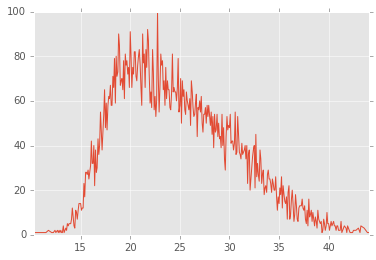

In [85]:
df.agepreg.value_counts().sort_index().plot();

Compute the mean birthweight.

In [86]:
df.totalwgt_lb.mean()

7.265628457623368

Create a new column named totalwgt_kg that contains birth weight in kilograms. Compute its mean. Remember that when you create a new column, you have to use dictionary syntax, not dot notation

In [87]:
df['totalwgt_kg'] = (0.453592)*df.totalwgt_lb
df.totalwgt_kg.mean()

3.2956309433503437

Use a boolean Series to select the records for the pregnancies that ended in live birth.

In [88]:
live = df[df.outcome == 1]
len(live)

9148

Count the number of live births with birthwgt_lb between 0 and 5 pounds (including both). The result should be 1125.

In [89]:
len(live[(live.birthwgt_lb >= 0) & (live.birthwgt_lb <= 5)])

1125

Count the number of live births with birthwgt_lb between 9 and 95 pounds (including both). The result should be 798

In [90]:
live[(live.birthwgt_lb <= 95) & 
    (live.birthwgt_lb >= 9)].shape

(798, 245)

Use ```birthord``` to select the records for first babies and others. How many are there of each?

In [92]:
firsts = df[df.birthord==1]
others = df[df.birthord>1]
len(firsts), len(others)

(4413, 4735)

Compute the mean weight for first babies and others.

In [95]:
print("Mean weight for first babies: {}".format(firsts.totalwgt_lb.mean()))
print("Mean weight for others babies: {}".format(others.totalwgt_lb.mean()))

Mean weight for first babies: 7.201094430437772
Mean weight for others babies: 7.325855614973262


Compute the mean prglngth for first babies and others. Compute the difference in means, expressed in hours.

In [97]:
a = firsts.prglngth.mean()
b = others.prglngth.mean()

c = (a - b)*168.0

print("Mean pregnancy length for first borns: {}".format(a))
print("Mean pregnancy length for others: {}".format(b))
print("Difference between mean first and others pregnancy lengths in hrs: {}".format(c))

Mean pregnancy length for first borns: 38.60095173351461
Mean pregnancy length for others: 38.52291446673706
Difference between mean first and others pregnancy lengths in hrs: 13.11026081862832


In [99]:
def get_value(vals):
    import random
    pval = random.uniform(0,100)
    #print(pval)
    return np.percentile(vals,pval)


def get_group(vals, numberofsubjects):
    """Returns a pandas series."""
    import random
    a = list()
    for i in range(numberofsubjects):
        try:
            b = get_value(vals)
            a.append(b)
        except:
            pass
    c = pd.Series(a)
    return c

First plot the empirical CDFs of prglngth for firsts and others.
You can visually see the differnce between the two in the plot.

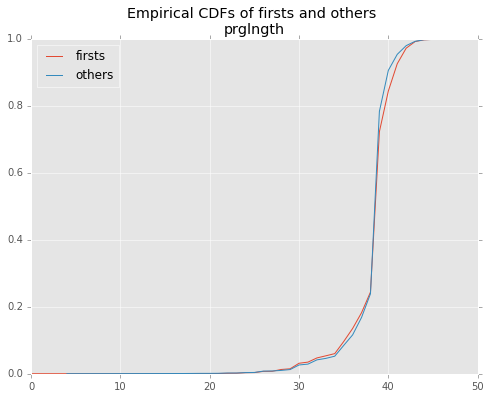

In [120]:
firsts_data = firsts.prglngth.value_counts(normalize=True).sort_index().cumsum()
others_data = others.prglngth.value_counts(normalize=True).sort_index().cumsum()

dfdata = pd.DataFrame({'firsts': firsts_data,
                     'others': others_data})
dfdata = dfdata.fillna(method='ffill')
dfdata.plot(figsize=(8,6), title = "Empirical CDFs of firsts and others \n" + 
           "prglngth")

So the mean pregnancy length is longer for first born babies than others; but how statistically significant is this observation.

Let's compute the cumulative distribution functions of pregnancy lengths for both first borns and others. Then we will sample form these empirical distribtions and so how often firsts are born later than others.

In [121]:
firsts_prglngth_vals = firsts.prglngth.values
others_prglngth_vals = others.prglngth.values

firstssamp = get_group(firsts_prglngth_vals, 1500)
otherssamp = get_group(others_prglngth_vals, 1500)

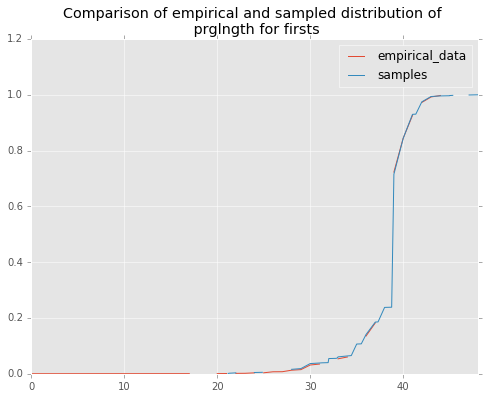

In [122]:
samples = firstssamp.value_counts(normalize=True).sort_index().cumsum()
real = firsts.prglngth.value_counts(normalize=True).sort_index().cumsum()
dffirsts = pd.DataFrame({'samples': samples,
                        'empirical_data': real })
dfffirsts = dffirsts.fillna(method='ffill')
dffirsts.plot(figsize=(8,6),title="Comparison of empirical " + \
              "and sampled distribution of \n prglngth for firsts");

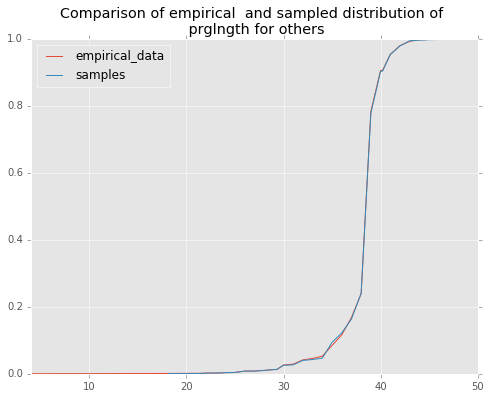

In [123]:
samples = otherssamp.value_counts(normalize=True).sort_index().cumsum()
real = others.prglngth.value_counts(normalize=True).sort_index().cumsum()
dfothers = pd.DataFrame({'samples': samples,
                        'empirical_data': real })
dfothers = dfothers.fillna(method='ffill')
dfothers.plot(figsize=(8,6),title="Comparison of empirical " + \
                          " and sampled distribution of \n prglngth for others");

In [124]:
(firstssamp > otherssamp).values.mean()

0.39066666666666666

So we can see here that there is a 39&#37; chance that in any given comparison between a first born and others born baby that the first born child will be born later. Not significant. Both the empiracle distributions and the distributions from sampling have a cross-over; for babies born between 30 and 38 weeks, firsts are acutally more likely to be earlier than others.

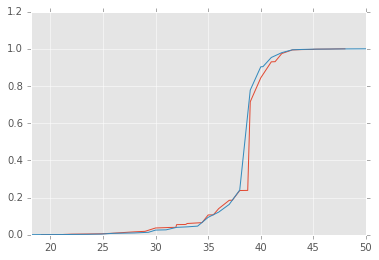

In [125]:
firstssamp.value_counts(normalize=True).sort_index().cumsum().plot();
otherssamp.value_counts(normalize=True).sort_index().cumsum().plot();